In [1]:
import sys
import os
current = os.path.dirname(os.path.abspath("__file__"))
parent = os.path.dirname(current)
sys.path.append(parent)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from scipy.stats import qmc
from scipy.stats import spearmanr
import graph_tool.all as gt
from datetime import timedelta
import ast
import re
from API.ES_gt import evolutionary_strategy

In [92]:
def range_data(df, init_time, end_time, delta):

    df['Time'] = pd.to_datetime(df['Time'], utc=True)
    it = pd.to_datetime(init_time) + timedelta(minutes=delta)
    et = pd.to_datetime(end_time) + timedelta(minutes=delta)

    return df[(df['Time'] >= it) & (df['Time'] <= et)]

def summary_table(original_df, evolved_df, simple_df, random_df, column_name):

    sum_table = pd.concat([original_df[column_name].describe(), 
                            evolved_df[column_name].describe(), 
                            simple_df[column_name].describe(), 
                            random_df[column_name].describe()], 
                            axis=1)
    sum_table.columns= ['Original', 'Evolved', 'Simple', 'Random']

    for column in sum_table.columns:
        for idx in sum_table.index[1:]:
            sum_table.at[idx,column] = round(sum_table.at[idx,column],3)

    return sum_table

def stat_test(evolved_df, comparable_df, column_name, comparable_df_name, metric_name):
    stat, p_value = mannwhitneyu(evolved_df[column_name], comparable_df[column_name])
    t1 = f'Evolved vs {comparable_df_name}'
    t2 = f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}'
    t3 = f'Null hypothesis: the distribution of {metric_name.lower()} is the same in the Evolved and {comparable_df_name} datasets.'
    if p_value > 0.05:
        #'Same distribution (fail to reject H0)'
        t4 = 'Result: We do not reject the null hypothesis'
    else:
        #'Different distribution, (reject H0)'
        t4 = 'Result: We reject the null hypothesis'
    return t1+'\n'+t2+'\n'+t3+'\n'+t4

def plot_results(original_df, evolved_df, simple_df, random_df, column_name, metric_name, x_lablel):
    
    sum_table = summary_table(original_df, evolved_df, simple_df, random_df, column_name)

    original_df['Dataset'] = 'Original'
    evolved_df['Dataset'] = 'Evolved'
    simple_df['Dataset'] = 'Simple'
    random_df['Dataset'] = 'Random'

    data = pd.concat([original_df, evolved_df, simple_df, random_df], ignore_index=True).reset_index(drop=True)

    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(9, 15))
    sns.violinplot(x=column_name, y='Dataset', data=data, cut=0, ax=ax1)
    ax1.set_title(f'{metric_name} comparison \n')
    ax1.set_xlabel(x_lablel)
    ax2.table(cellText=sum_table.values, 
            colLabels=sum_table.columns, 
            cellLoc='center', 
            rowLabels=sum_table.index,
            bbox=(0, 0.5, 1, 0.5))
    ax2.text(0, 0.35, stat_test(evolved_df, original_df, column_name, 'Original', metric_name))
    ax2.text(0, 0.2, stat_test(evolved_df, simple_df, column_name, 'Simple', metric_name))
    ax2.text(0, 0.05, stat_test(evolved_df, random_df, column_name, 'Random', metric_name))
    ax2.axis('off')

    return fig

def plot_lines(ori, evo, sim, ran, title, column, ylabel, percentage=True):
    ori = ori.reset_index(drop=True)
    evo = evo.reset_index(drop=True)
    sim = sim.reset_index(drop=True)
    ran = ran.reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(ori.index, ori[column], label='Original')
    ax.plot(evo.index, evo[column], label='Evolved')
    ax.plot(sim.index, sim[column], label='Simple')
    ax.plot(ran.index, ran[column], label='Random')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, ncol=4)
    ax.set_title(title)
    ax.set_xlabel('Time [h]')
    ax.set_ylabel(ylabel)
    if percentage:
        yticks = ax.get_yticks()
        yticks = [round(100 * tick,1) for tick in yticks]
        ax.set_yticklabels(yticks)
    
    return fig

In [84]:
# Original dataset loading time
ori_it, ori_et = '2023-01-03T02:47:49Z','2023-01-03T12:41:11Z'
# Evolved dataset loading time
evo_it, evo_et = '2023-01-04T05:00:17Z','2023-01-05T14:16:52Z'
# Expanded simple version loading time
sim_it, sim_et = '2023-01-06T11:33:18Z','2023-01-07T14:44:08Z'
# Expanded random version loading time
ran_it, ran_et = '2023-01-08T08:11:45Z','2023-01-09T15:56:08Z'

# Error ratio data:
ori = pd.read_csv('Results_complete_ds/Original/Error Ratios-data-2023-01-03 22 56 51.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/Evolved/Error Ratios-data-2023-01-05 22 00 43.csv')
sim = pd.read_csv('Results_complete_ds/Simple/Error Ratios-data-2023-01-07 20 31 55.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/Random/Error Ratios-data-2023-01-09 21 55 26.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,15)
evo = range_data(evo, evo_it, evo_et,15)
sim = range_data(sim, sim_it, sim_et,15)
ran = range_data(ran, ran_it, ran_et,15)

In [58]:
# Error ratio plot:
fig = plot_results(ori, evo, sim, ran, 'postgres service', 'Error ratio', '% Requests in error')
fig.savefig('Plots/fig1.pdf')
plt.close()

/var/folders/3k/tk51r55962751zt89q_rcgfw0000gn/T/ipykernel_4735/986140659.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


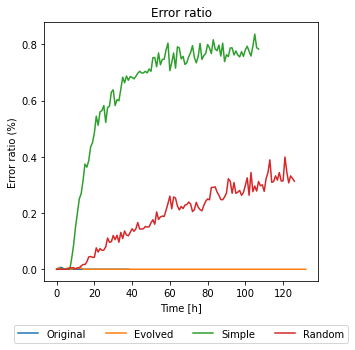

In [93]:
fig = plot_lines(ori, evo, sim, ran, 'Error ratio', 'postgres service', 'Error ratio (%)')
fig.tight_layout()
fig.savefig('Plots/Errors1k.pdf')
# plt.close()

In [94]:
# Memory utilisation data:
ori = pd.read_csv('Results_complete_ds/Original/Memory Utilization-data-2023-01-03 22 57 58.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/Evolved/Memory Utilization-data-2023-01-05 22 04 42.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/Simple/Memory Utilization-data-2023-01-07 20 32 55.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/Random/Memory Utilization-data-2023-01-09 21 56 17.csv', skiprows=1)

ori.columns = ['Time', 'Memory']
evo.columns = ['Time', 'Memory']
sim.columns = ['Time', 'Memory']
ran.columns = ['Time', 'Memory']

ori = range_data(ori, ori_it, ori_et,5)
evo = range_data(evo, evo_it, evo_et,5)
sim = range_data(sim, sim_it, sim_et,5)
ran = range_data(ran, ran_it, ran_et,5)

In [7]:
# Memory utilisation plot:
fig = plot_results(ori, evo, sim, ran, 'Memory', 'Memory utilisation', '% Memory saturation')
fig.savefig('Plots/fig2.pdf')
plt.close()

/var/folders/3k/tk51r55962751zt89q_rcgfw0000gn/T/ipykernel_4735/986140659.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


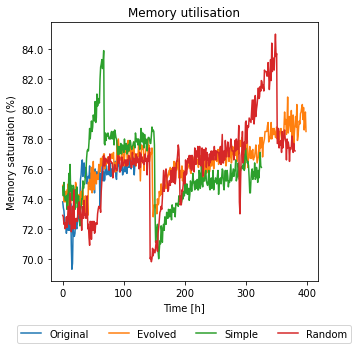

In [95]:
fig = plot_lines(ori, evo, sim, ran, 'Memory utilisation', 'Memory', 'Memory saturation (%)')
fig.tight_layout()
fig.savefig('Plots/Mem1k.pdf')
# plt.close()

In [96]:
# CPU saturation data:
ori = pd.read_csv('Results_complete_ds/Original/Saturation-data-as-seriestocolumns-2023-01-03 22 56 38.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/Evolved/Saturation-data-as-seriestocolumns-2023-01-05 22 00 00.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/Simple/Saturation-data-as-seriestocolumns-2023-01-07 20 31 32.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/Random/Saturation-data-as-seriestocolumns-2023-01-09 21 55 14.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,15)
evo = range_data(evo, evo_it, evo_et,15)
sim = range_data(sim, sim_it, sim_et,15)
ran = range_data(ran, ran_it, ran_et,15)

In [10]:
# CPU saturation plot:
fig = plot_results(ori, evo, sim, ran, 'cpu saturation', 'CPU saturation', '% CPU saturation')
fig.savefig('Plots/fig3.pdf')
plt.close()

/var/folders/3k/tk51r55962751zt89q_rcgfw0000gn/T/ipykernel_4735/986140659.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


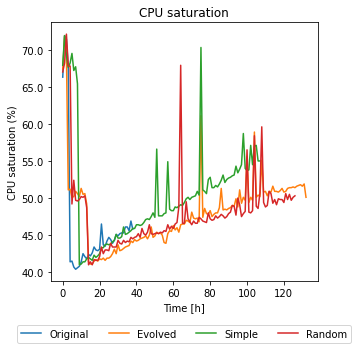

In [97]:
fig = plot_lines(ori, evo, sim, ran, 'CPU saturation', 'cpu saturation', 'CPU saturation (%)')
fig.tight_layout()
fig.savefig('Plots/CPU1k.pdf')
# plt.close()

In [98]:
# RPS data:
ori = pd.read_csv('Results_complete_ds/Original/RPS - Service Requests per Second-data-2023-01-03 22 57 02.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/Evolved/RPS - Service Requests per Second-data-2023-01-05 22 01 06.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/Simple/RPS - Service Requests per Second-data-2023-01-07 20 32 07.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/Random/RPS - Service Requests per Second-data-2023-01-09 21 55 36.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,15)
evo = range_data(evo, evo_it, evo_et,15)
sim = range_data(sim, sim_it, sim_et,15)
ran = range_data(ran, ran_it, ran_et,15)

In [13]:
# RPS plot:
fig = plot_results(ori, evo, sim, ran, 'gitlab-workhorse', 'Requests per second', 'Operations per second')
fig.savefig('Plots/fig4.pdf')
plt.close()

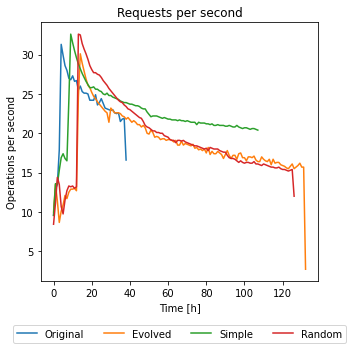

In [99]:
fig = plot_lines(ori, evo, sim, ran, 'Requests per second', 'gitlab-workhorse', 'Operations per second', False)
fig.tight_layout()
fig.savefig('Plots/RPS1k.pdf')
# plt.close()

In [100]:
# Latency data:
ori = pd.read_csv('Results_complete_ds/Original/Latency-data-2023-01-03 22 58 27.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/Evolved/Latency-data-2023-01-05 22 05 51.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/Simple/Latency-data-2023-01-07 20 33 16.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/Random/Latency-data-2023-01-09 21 56 51.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,2)
evo = range_data(evo, evo_it, evo_et,2)
sim = range_data(sim, sim_it, sim_et,2)
ran = range_data(ran, ran_it, ran_et,2)

In [101]:
# Latency plot:
fig = plot_results(ori, evo, sim, ran, 'localhost:8060', 'System latency', 'Latency (ms)')
fig.savefig('Plots/fig5.pdf')
plt.close()

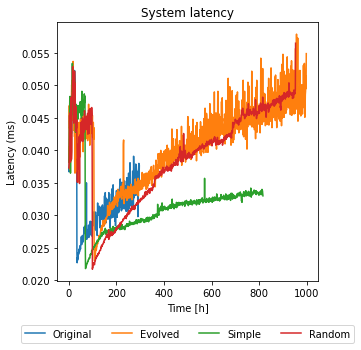

In [102]:
fig = plot_lines(ori, evo, sim, ran, 'System latency', 'localhost:8060', 'Latency (ms)', False)
fig.tight_layout()
fig.savefig('Plots/Lat1k.pdf')
#plt.close()

In [18]:
# Original dataset loading time
ori_it, ori_et = '2023-01-03T02:47:49Z','2023-01-03T12:41:11Z'
# Evolved dataset loading time
evo_it, evo_et = '2023-01-14T04:45:55Z','2023-01-16T05:29:26Z'
# Expanded simple version loading time
sim_it, sim_et = '2023-01-19T07:27:52Z','2023-01-19T19:24:11Z'
# Expanded random version loading time
ran_it, ran_et = '2023-01-16T10:40:52Z','2023-01-18T19:37:38Z'

# Error ratio data:
ori = pd.read_csv('Results_complete_ds/Original/Error Ratios-data-2023-01-03 22 56 51.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/10KEvolved/Error Ratios-data-2023-01-16 10 04 42.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/10kSimple/Error Ratios-data-2023-01-19 20 33 56.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/10KRandom/Error Ratios-data-2023-01-18 22 27 52.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,15)
evo = range_data(evo, evo_it, evo_et,60)
sim = range_data(sim, sim_it, sim_et,60)
ran = range_data(ran, ran_it, ran_et,60)

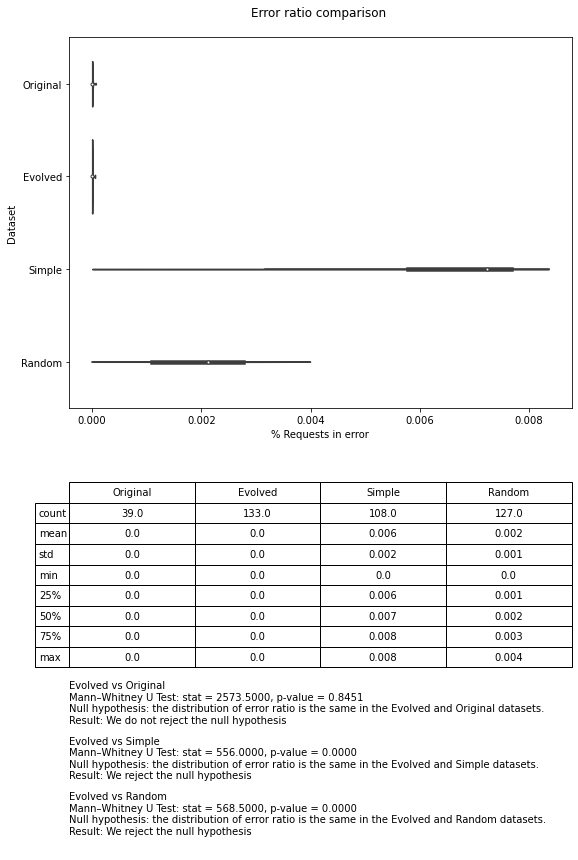

In [7]:
# Error ratio plot:
fig = plot_results(ori, evo, sim, ran, 'postgres service', 'Error ratio', '% Requests in error')
fig.savefig('Plots/fig6.pdf')
# plt.close()

In [20]:
fig = plot_lines(ori, evo, sim, ran, 'Error ratio', 'postgres service', 'Error ratio')
fig.savefig('Plots/Errors10k.pdf')
plt.close()

In [21]:
# Memory utilisation data:
ori = pd.read_csv('Results_complete_ds/Original/Memory Utilization-data-2023-01-03 22 57 58.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/10KEvolved/Memory Utilization-data-2023-01-16 10 05 35.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/10kSimple/Memory Utilization-data-2023-01-19 20 34 45.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/10KRandom/Memory Utilization-data-2023-01-18 22 28 43.csv', skiprows=1)

ori.columns = ['Time', 'Memory']
evo.columns = ['Time', 'Memory']
sim.columns = ['Time', 'Memory']
ran.columns = ['Time', 'Memory']

ori = range_data(ori, ori_it, ori_et,5)
evo = range_data(evo, evo_it, evo_et,20)
sim = range_data(sim, sim_it, sim_et,20)
ran = range_data(ran, ran_it, ran_et,20)

In [22]:
# Memory utilisation plot:
fig = plot_results(ori, evo, sim, ran, 'Memory', 'Memory utilisation', '% Memory saturation')
fig.savefig('Plots/fig7.pdf')
plt.close()

In [23]:
fig = plot_lines(ori, evo, sim, ran, 'Memory utilisation', 'Memory', '% Memory saturation')
fig.savefig('Plots/Mem10k.pdf')
plt.close()

In [24]:
# CPU saturation data:
ori = pd.read_csv('Results_complete_ds/Original/Saturation-data-as-seriestocolumns-2023-01-03 22 56 38.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/10KEvolved/Saturation-data-as-seriestocolumns-2023-01-16 10 04 28.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/10kSimple/Saturation-data-as-seriestocolumns-2023-01-19 20 33 36.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/10KRandom/Saturation-data-as-seriestocolumns-2023-01-18 22 27 39.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,15)
evo = range_data(evo, evo_it, evo_et,60)
sim = range_data(sim, sim_it, sim_et,60)
ran = range_data(ran, ran_it, ran_et,60)

In [25]:
# CPU saturation plot:
fig = plot_results(ori, evo, sim, ran, 'cpu saturation', 'CPU saturation', '% CPU saturation')
fig.savefig('Plots/fig8.pdf')
plt.close()

In [26]:
fig = plot_lines(ori, evo, sim, ran, 'CPU saturation', 'cpu saturation', '% CPU saturation')
fig.savefig('Plots/CPU10k.pdf')
plt.close()

In [27]:
# RPS data:
ori = pd.read_csv('Results_complete_ds/Original/RPS - Service Requests per Second-data-2023-01-03 22 57 02.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/10KEvolved/RPS - Service Requests per Second-data-2023-01-16 10 04 52.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/10kSimple/RPS - Service Requests per Second-data-2023-01-19 20 34 07.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/10KRandom/RPS - Service Requests per Second-data-2023-01-18 22 31 01.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,15)
evo = range_data(evo, evo_it, evo_et,60)
sim = range_data(sim, sim_it, sim_et,60)
ran = range_data(ran, ran_it, ran_et,60)

In [28]:
# RPS plot:
fig = plot_results(ori, evo, sim, ran, 'gitlab-workhorse', 'Requests per second', 'Operations per second')
fig.savefig('Plots/fig9.pdf')
plt.close()

In [30]:
fig = plot_lines(ori, evo, sim, ran, 'Requests per second', 'gitlab-workhorse', 'Operations per second')
fig.savefig('Plots/RPS10k.pdf')
plt.close()

In [31]:
# Latency data:
ori = pd.read_csv('Results_complete_ds/Original/Latency-data-2023-01-03 22 58 27.csv',skiprows=1)
evo = pd.read_csv('Results_complete_ds/10KEvolved/Latency-data-2023-01-16 10 06 00.csv',skiprows=1)
sim = pd.read_csv('Results_complete_ds/10kSimple/Latency-data-2023-01-19 20 35 17.csv', skiprows=1)
ran = pd.read_csv('Results_complete_ds/10KRandom/Latency-data-2023-01-18 22 29 20.csv', skiprows=1)

ori = range_data(ori, ori_it, ori_et,2)
evo = range_data(evo, evo_it, evo_et,10)
sim = range_data(sim, sim_it, sim_et,10)
ran = range_data(ran, ran_it, ran_et,10)

In [32]:
# Latency plot:
fig = plot_results(ori, evo, sim, ran, 'localhost:8060', 'System latency', 'Latency (ms)')
fig.savefig('Plots/fig10.pdf')
plt.close()

In [33]:
fig = plot_lines(ori, evo, sim, ran, 'System latency', 'localhost:8060', 'Latency (ms)')
fig.savefig('Plots/Lat10k.pdf')
plt.close()

In [2]:
# Star-discrepancy 1k:
ori = pd.read_csv('Original_dataset.csv')
evo = pd.read_csv('Mutated_dataset.csv')
sim = pd.read_csv('expanded_ds_simple.csv')
ran = pd.read_csv('expanded_ds_random.csv')

In [48]:
def draw_network(edgelist, output):
    g = gt.Graph(directed=True)
    vertices = g.add_edge_list(edgelist[['source', 'target']].to_numpy(), hashed=True)
    pos = gt.sfdp_layout(g)
    pr = gt.pagerank(g)
    gt.graph_draw(g, 
              pos=pos, 
              vertex_fill_color=pr,
              vertex_size=gt.prop_to_size(pr, mi=5, ma=15), 
              vorder=pr, 
              vcmap=plt.cm.summer,
              output=output)

In [49]:
draw_network(ori, "Plots/Original_network_1k.pdf")
draw_network(evo, "Plots/Evolved_network_1k.pdf")
draw_network(sim, "Plots/Simple_network_1k.pdf")
draw_network(ran, "Plots/Random_network_1k.pdf")
  

In [4]:
es = evolutionary_strategy(ori[ori['type'] != 'FollowEvent'])
combinations = es.combinations

def map_combinations(edge_list):
    edge_list = edge_list.loc[edge_list['type'] != 'FollowEvent'].reset_index(drop=True)
    map_values = edge_list[['source','type']].groupby('source').apply(lambda x: combinations.get(tuple(sorted(x['type'].unique()))))
    return map_values


def complete_dataset(dataset):
    vertices = dataset[['source', 'target']].to_numpy()
    G = gt.Graph(directed=True)
    vertices = G.add_edge_list(vertices, hashed=True)
    ranks = gt.pagerank(G)
    d = [{'vertices':name, 'pagerank':ranks[vertex], 'degree':vertex.out_degree()+vertex.in_degree()} for vertex, name in zip(G.vertices(), vertices)]
    result = pd.DataFrame(d).set_index('vertices')
    result = result[result.index.str.startswith('u: ')]
    mapped_values = map_combinations(dataset)
    result = pd.concat([result, mapped_values], axis=1, ignore_index=False).rename(columns={0:'Values'})
    result = result.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 0)
    return result

def evaluation(dataset): return qmc.discrepancy(dataset, method='L2-star',workers=-1)

def data_from_log(path, dataset_name):
    with open(path, encoding='utf-8') as f:
        df = " ".join(line.strip() for line in f)

    # Split the string on the curly braces
    df = re.findall(r'\{[^}]*\}', df)
    df = [ast.literal_eval(item) for item in df]
    # Transform list to pandas df:
    df = pd.DataFrame(df)
    # Filter out WARNING messages:
    df = df[df['levelname'] != 'WARNING'].reset_index(drop=True)
    # get initial, end time:
    ini_time = df.time[0]
    end_time = df.time[df.shape[0]-1]
    loading_time = round((pd.to_datetime(end_time) - pd.to_datetime(ini_time)).total_seconds()/3600,1)

    return f'{dataset_name} \n Total loading time: {loading_time} hrs.' #dataset \n start: {ini_time} \n end: {end_time} 

def draw_3d_plot(ax, data, suptitle, size, long_title=True):
    
    ax = ax or plt.gca()
    
    ax.scatter3D(data['degree'], data['pagerank'], data['Values'], edgecolor='b', c='c')
    ax.set_xlabel('Degree centrality', fontsize=12)
    ax.set_ylabel('PageRank', fontsize=12)
    ax.set_zlabel('Event type', fontsize=12)
    if long_title:
        ax.set_title(f'{suptitle} \n Star-discrepancy score: {evaluation(data):.3f} \n Edge list size: {size:,}', fontsize=12)
    else:
        ax.set_title(f'Star-discrepancy score: {evaluation(data):.3f}', y=-0.4, fontsize=12)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    
    return ax

def draw_2d_plot(ax, x, y, xlabel, ylabel):

    ax.scatter(x, y,edgecolor='b', c='c')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    return ax

def draw_plot(ds, log_path, dataset_name):
    data = complete_dataset(ds)

    fig = plt.figure(figsize=(25, 5))

    # 3d plot (Centrality, pagerank, event type)
    ax1 = fig.add_subplot(1,4,1, projection='3d')
    ax1 = draw_3d_plot(ax1, data, data_from_log(log_path, dataset_name), len(ds))
    # pagerank vs centrality
    ax2 = fig.add_subplot(1,4,2)
    ax2 = draw_2d_plot(ax2, data['degree'], data['pagerank'],'Degree centrality', 'PageRank')
    # pagerank vs event type
    ax3 = fig.add_subplot(1,4,3)
    ax3 = draw_2d_plot(ax3, data['Values'], data['pagerank'],'Event type', 'PageRank')
    # centrality vs event type
    ax4 = fig.add_subplot(1,4,4)
    ax4 = draw_2d_plot(ax4, data['Values'], data['degree'], 'Event type', 'Degree centrality')

    return fig


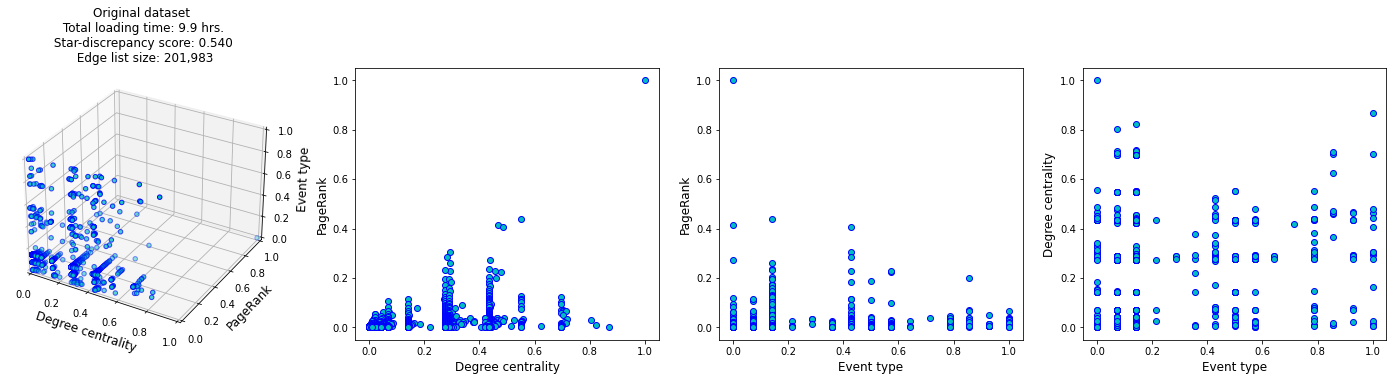

In [137]:
fig = draw_plot(ori, '/Users/francisco/Public/log_file_original.log', 'Original dataset')
fig.savefig('Plots/3Dplus2D_Original.pdf')


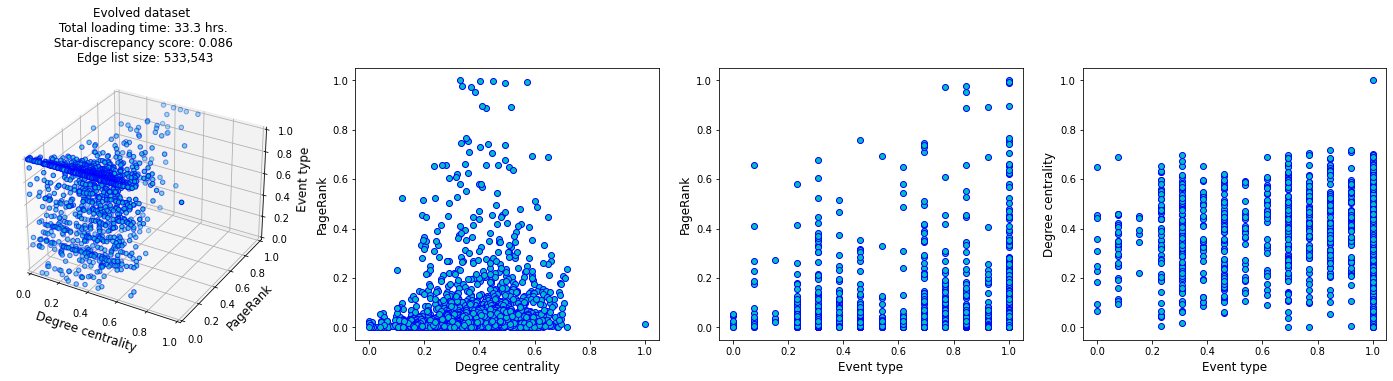

In [138]:
fig = draw_plot(evo, '/Users/francisco/Public/log_file_evolved.log', 'Evolved dataset')
fig.savefig('Plots/3Dplus2D_Evolved.pdf')

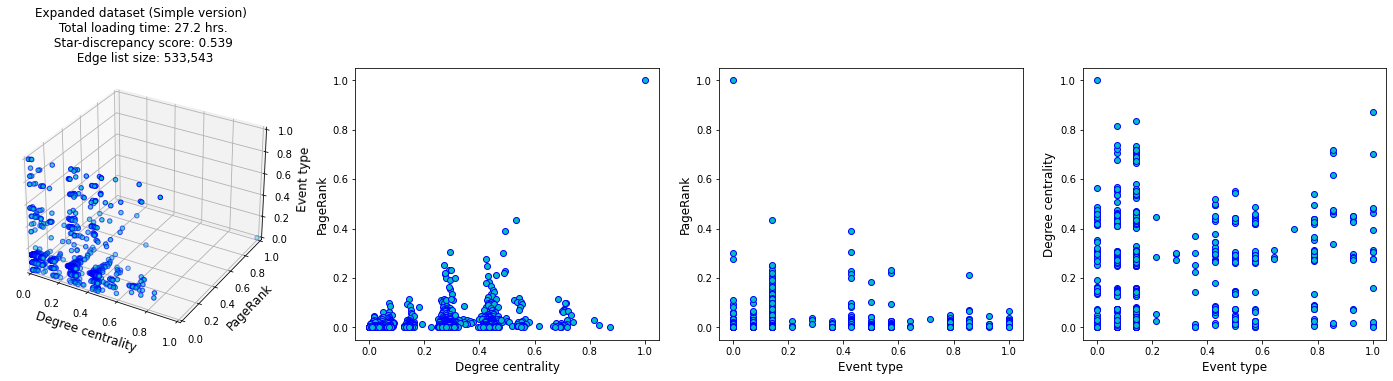

In [139]:
fig = draw_plot(sim, '/Users/francisco/Public/log_file_simple.log', 'Expanded dataset (Simple version)')
fig.savefig('Plots/3Dplus2D_Simple.pdf')

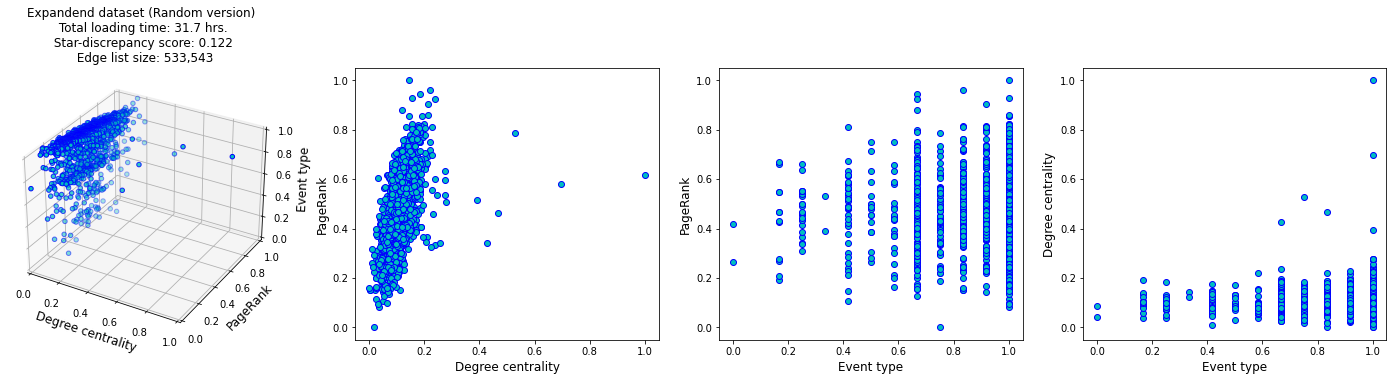

In [140]:
fig = draw_plot(ran, '/Users/francisco/Public/log_file_random.log', 'Expandend dataset (Random version)')
fig.savefig('Plots/3Dplus2D_Random.pdf')

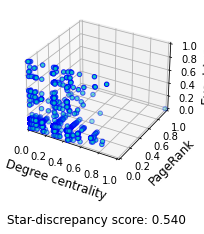

In [133]:
fig, ax1 = plt.subplots(figsize=(5,5),subplot_kw=dict(projection="3d"), layout="constrained")
ax1 = draw_3d_plot(ax1, complete_dataset(ori),'','', long_title=False)
fig.tight_layout(pad=5.0)
fig.savefig('Plots/Original_individual.pdf')

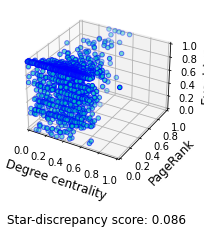

In [134]:
fig, ax1 = plt.subplots(figsize=(5,5),subplot_kw=dict(projection="3d"), layout="constrained")
ax1 = draw_3d_plot(ax1, complete_dataset(evo),'','', long_title=False)
fig.tight_layout(pad=5.0)
fig.savefig('Plots/Evolved_individual.pdf')

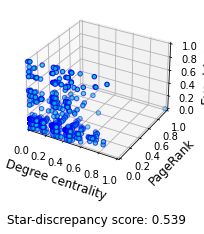

In [135]:
fig, ax1 = plt.subplots(figsize=(5,5),subplot_kw=dict(projection="3d"), layout="constrained")
ax1 = draw_3d_plot(ax1, complete_dataset(sim),'','', long_title=False)
fig.tight_layout(pad=5.0)
fig.savefig('Plots/Simple_individual.pdf')

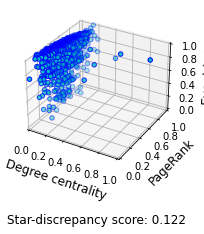

In [136]:
fig, ax1 = plt.subplots(figsize=(5,5),subplot_kw=dict(projection="3d"), layout="constrained")
ax1 = draw_3d_plot(ax1, complete_dataset(ran),'','', long_title=False)
fig.tight_layout(pad=5.0)
fig.savefig('Plots/Random_individual.pdf')

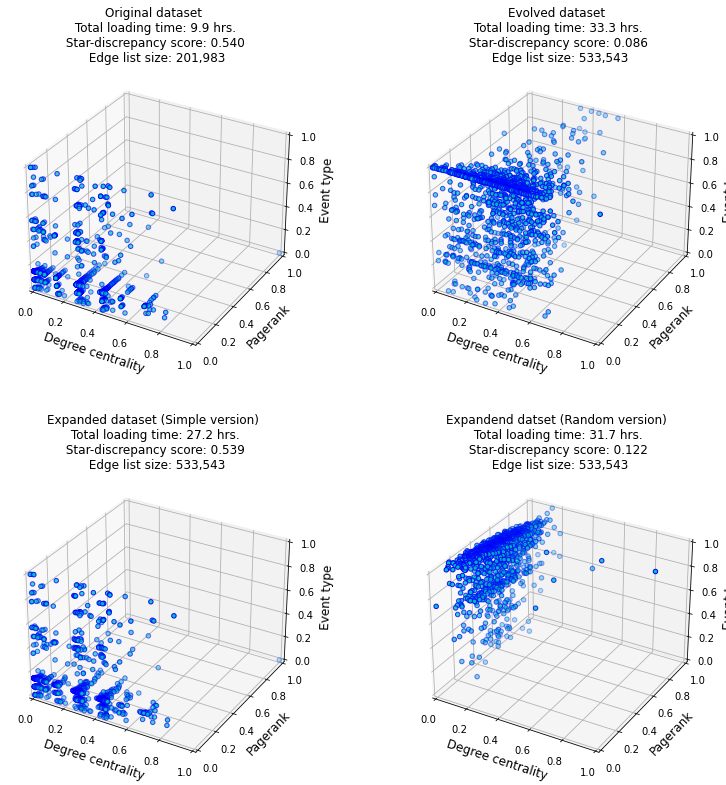

In [126]:
fig, axes = plt.subplots(2,2, figsize=(12,12), subplot_kw=dict(projection="3d"))

ax1, ax2, ax3, ax4 = axes.flatten()
ax1 = draw_3d_plot(ax1, complete_dataset(ori), data_from_log('/Users/francisco/Public/log_file_original.log', 'Original dataset'), len(ori))
ax2 = draw_3d_plot(ax2, complete_dataset(evo), data_from_log('/Users/francisco/Public/log_file_evolved.log', 'Evolved dataset'),len(evo))
ax3 = draw_3d_plot(ax3, complete_dataset(sim), data_from_log('/Users/francisco/Public/log_file_simple.log', 'Expanded dataset (Simple version)'), len(sim))
ax4 = draw_3d_plot(ax4, complete_dataset(ran), data_from_log('/Users/francisco/Public/log_file_random.log', 'Expandend datset (Random version)'), len(ran))

fig.tight_layout(pad=5.0)

In [54]:
ds = pd.read_csv('/Users/francisco/Public/Reload1k/avg_resource_utilisation.csv')
ds = ds.set_index('source')
ds = ds.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 0)

ds = ds.join(complete_dataset(evo))
ds = ds.rename(columns={'pagerank':'PageRank','degree':'Degree Centrality', 'Values':'Event type', 'cpu':'CPU utilisation', 'mem': 'Memory utilisation', 'lat': 'Latency'})
ds

,CPU utilisation,Memory utilisation,Latency,PageRank,Degree Centrality,Event type
source,,,,,,
u: 0532,0.714946,0.544492,0.517926,0.016677,0.512286,1.000000
u: 0x00,0.744124,0.522804,0.612149,0.013174,0.576322,0.615385
u: 12-tp9d,0.562237,0.430053,0.150270,0.154832,0.629188,0.230769
u: 234x,0.649679,0.485854,0.389619,0.017933,0.209978,0.461538
u: 4148,0.599987,0.545069,0.372326,0.041967,0.551005,1.000000
...,...,...,...,...,...,...
u: zenware,0.858179,0.614212,0.838127,0.001002,0.717796,0.923077
u: zgrep,0.590712,0.222263,0.284720,0.303564,0.501862,0.307692
u: zn,0.644751,0.505908,0.366549,0.033122,0.495160,1.000000


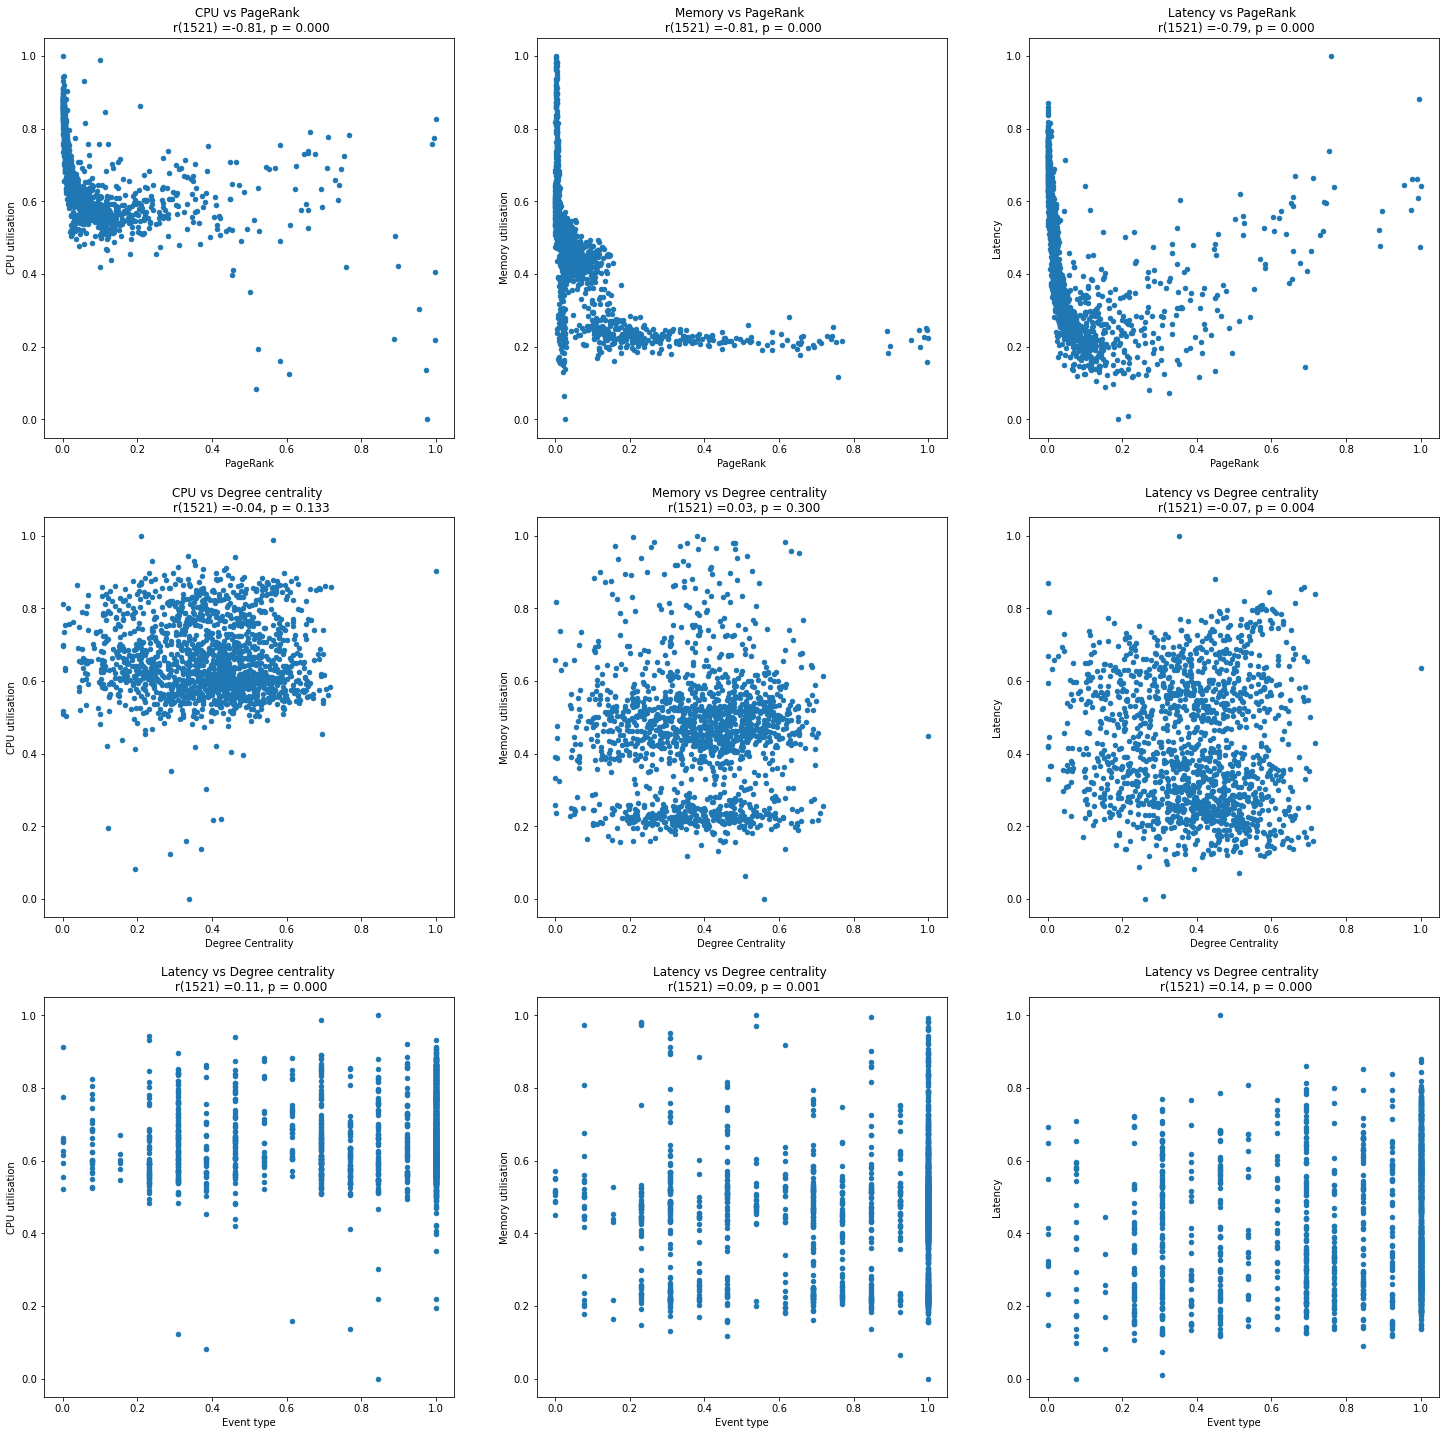

In [68]:
fig, axs = plt.subplots(3, 3, figsize=(25,25))

ds.plot(kind='scatter', x='PageRank', y='CPU utilisation', ax=axs[0,0])
res = spearmanr(ds['CPU utilisation'], ds['PageRank'])
axs[0,0].title.set_text(f'CPU vs PageRank \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='PageRank', y='Memory utilisation', ax=axs[0,1])
res = spearmanr(ds['Memory utilisation'], ds['PageRank'])
axs[0,1].title.set_text(f'Memory vs PageRank \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='PageRank', y='Latency',  ax=axs[0,2])
res = spearmanr(ds['Latency'], ds['PageRank'])
axs[0,2].title.set_text(f'Latency vs PageRank \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='Degree Centrality', y='CPU utilisation',  ax=axs[1,0])
res = spearmanr(ds['CPU utilisation'], ds['Degree Centrality'])
axs[1,0].title.set_text(f'CPU vs Degree centrality \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='Degree Centrality', y='Memory utilisation',  ax=axs[1,1])
res = spearmanr(ds['Memory utilisation'], ds['Degree Centrality'])
axs[1,1].title.set_text(f'Memory vs Degree centrality \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='Degree Centrality', y='Latency',  ax=axs[1,2])
res = spearmanr(ds['Latency'], ds['Degree Centrality'])
axs[1,2].title.set_text(f'Latency vs Degree centrality \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='Event type', y='CPU utilisation',  ax=axs[2,0])
res = spearmanr(ds['CPU utilisation'], ds['Event type'])
axs[2,0].title.set_text(f'Latency vs Degree centrality \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='Event type', y='Memory utilisation',  ax=axs[2,1])
res = spearmanr(ds['Memory utilisation'], ds['Event type'])
axs[2,1].title.set_text(f'Latency vs Degree centrality \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

ds.plot(kind='scatter', x='Event type', y='Latency',  ax=axs[2,2])
res = spearmanr(ds['Latency'], ds['Event type'])
axs[2,2].title.set_text(f'Latency vs Degree centrality \n r({len(ds)-2}) ={res.correlation:.2f}, p = {res.pvalue:.3f}')

In [50]:
# Star-discrepancy 10k:
ori = pd.read_csv('Original_dataset.csv')
evo = pd.read_csv('Mutated_dataset_10kiter.csv')
sim = pd.read_csv('expanded_dataset_simple10k.csv')
ran = pd.read_csv('expanded_dataset_random10k.csv')

In [52]:
draw_network(ori, "Plots/Original_network_10k.png")
draw_network(evo, "Plots/Evolved_network_10k.png")
draw_network(sim, "Plots/Simple_network_10k.png")
draw_network(ran, "Plots/Random_network_10k.png")

In [28]:
fig, axes = plt.subplots(2,2, figsize=(12,12), subplot_kw=dict(projection="3d"))

ax1, ax2, ax3, ax4 = axes.flatten()
ax1 = draw_plot(ax1, complete_dataset(ori), data_from_log('/Users/francisco/Public/log_file_original.log', 'Original dataset'), len(ori))
ax2 = draw_plot(ax2, complete_dataset(evo), data_from_log('/Users/francisco/Public/log_file_10kevolved.log', 'Evolved dataset'),len(evo))
ax3 = draw_plot(ax3, complete_dataset(sim), data_from_log('/Users/francisco/Public/log_file_10ksimple.log', 'Expanded dataset (Simple version)'), len(sim))
ax4 = draw_plot(ax4, complete_dataset(ran), data_from_log('/Users/francisco/Public/log_file_10krandom.log', 'Expandend datset (Random version)'), len(ran))

fig.tight_layout(pad=5.0)

In [29]:
fig.savefig('Plots/fig12.pdf')

In [74]:
def convergence_plot(path):

    with open(path, encoding='utf-8') as f:
        text_file = f.readlines()[1:]

    text_file = [line.rstrip() for line in text_file]
    text_file = [line.split(', ') for line in text_file]

    score = []
    sample_size = []

    for line in text_file:
        txt, scr = line[1].split(': ')
        score.append(scr)
        txt, sz = line[2].split('}')[0].split(': ')
        sample_size.append(sz)

    score = [float(s) for s in score]
    sample_size = [int(s) for s in sample_size]
    df = pd.DataFrame({'score':score, 'sample_size':sample_size})

    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax2 = ax1.twinx()
    
    ax1.plot(df.index, df.sample_size, 'b', label='Mutation rate')
    ax1.set_yscale('log')
    # ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())
    # ax1.ticklabel_format(style='plain')
    ax1.set_title('Success-based multiplicative update rule \n')
    ax1.set_ylabel('Mutation rate')
    ax1.set_xlabel('Iterations')

    ax2.plot(df.index, df.score, 'r', label='Evaluation score')
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax2.ticklabel_format(style='plain')
    ax2.set_ylabel('Star-discrepancy evaluation')

    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    #plt.close()

    return fig

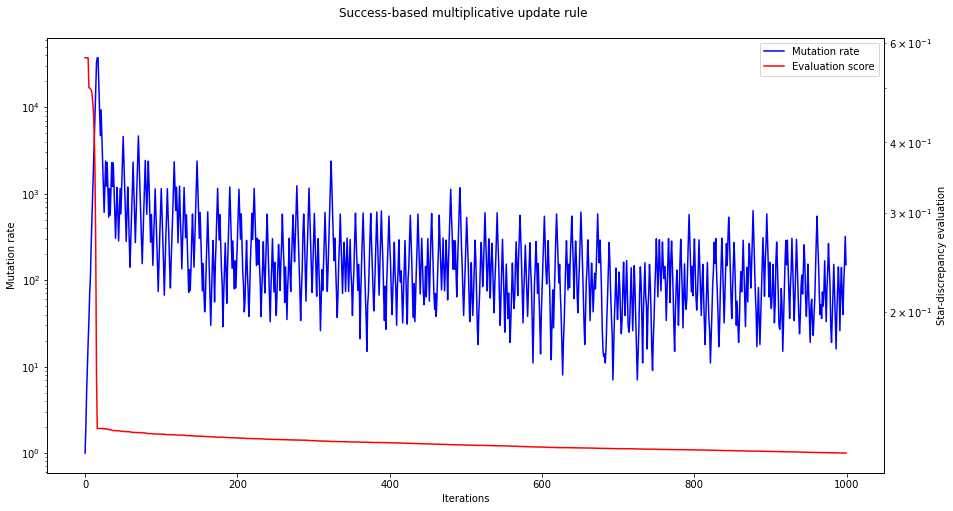

In [75]:
# plt.rc('font', size =20)
fig = convergence_plot('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/complete_logfile.txt')
# fig.savefig('Plots/fig13.pdf', bbox_inches='tight')

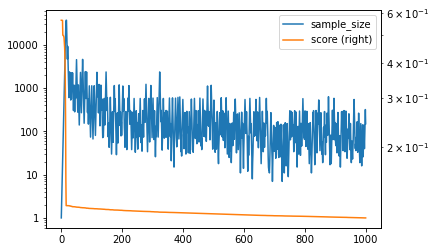

In [74]:
df = pd.read_csv('https://gist.githubusercontent.com/fzanart/50f4841374b58abbf054719cfff2c068/raw/logSO.csv')
fig, ax = plt.subplots()
df.plot(kind='line', y='sample_size', logy=True, ax = ax)
df.plot(kind='line', y='score', logy=True, ax = ax, secondary_y=True)

formatter = ticker.ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain')
ax.right_ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain')

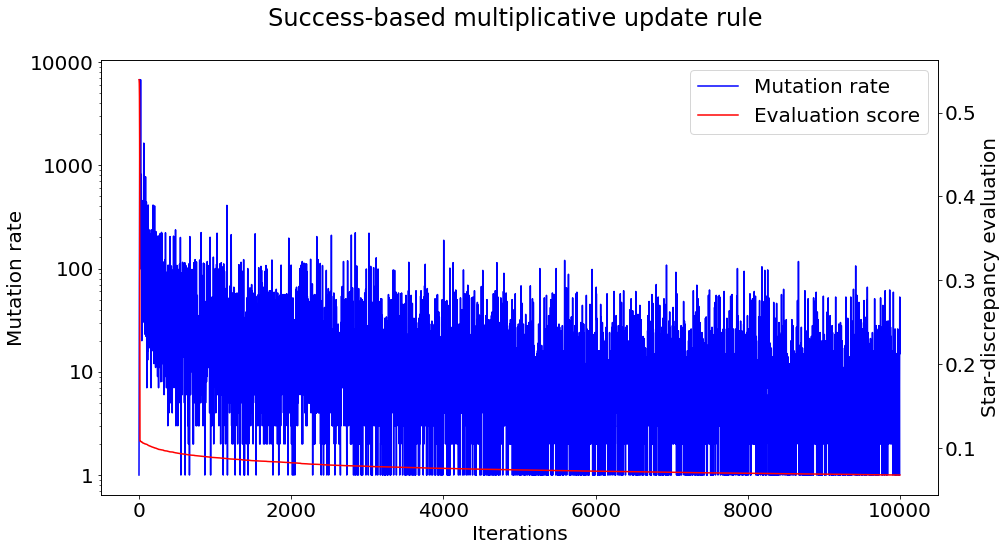

In [195]:
fig = convergence_plot('/Users/francisco/Downloads/logfile_gt10k.log')
# fig.savefig('Plots/fig14.pdf')